In [ ]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2022-08-14 14:04:34--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2022-08-14 14:04:35--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc541c52bc18790a6263725f8254.dl.dropboxusercontent.com/cd/0/inline/Bq_l8Xd9ZFB08jp6vbE6AndkO_tDpSeOwN-SZFk5EtYuja1k-fA7bbMnzrO68ZtHB6nU9B51CyosfKErw4JH2uC0-j32XlTSiT6TLAQHxE4RG_A0P56PwyBFH-At_kDjbOIiuGCH3OhFN6EoygSCjVTK03Px1f7NrPr3g4My-mQzcw/file# [following]
--2022-08-14 14:04:36--  https://uc541c52bc18790a6263725f8254.dl.dropboxusercontent.com/cd/0/inline/Bq_l8Xd9ZFB08jp6vbE6AndkO_tDpSeOwN-SZFk5EtYuja1k-fA7bbMnzrO68ZtHB6nU

In [ ]:
!unzip -q "/content/archive.zip"

In [ ]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [ ]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/neutral/Training_86199569.jpg',
 '/content/train/neutral/Training_18717817.jpg',
 '/content/train/neutral/Training_15959825.jpg',
 '/content/train/neutral/Training_86871749.jpg',
 '/content/train/neutral/Training_38941586.jpg',
 '/content/train/neutral/Training_76328121.jpg',
 '/content/train/neutral/Training_36368816.jpg',
 '/content/train/neutral/Training_18292307.jpg',
 '/content/train/neutral/Training_26155110.jpg',
 '/content/train/neutral/Training_96958424.jpg']

In [ ]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral']

In [ ]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [ ]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8351796, 1: 15.800578, 2: 1.7871853, 3: 1.0, 4: 1.4807693, 5: 1.5010983, 6: 2.3303494}


In [ ]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [ ]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 682 ms, sys: 16 ms, total: 698 ms
Wall time: 854 ms
(32, 96, 96, 3)
(32, 7)


fear


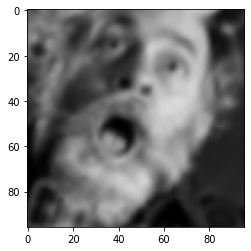

In [ ]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 24.2 ms
(32, 96, 96, 3)
(32, 7)


happy


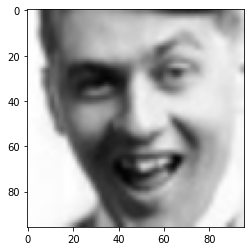

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31801344/31790344 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non

In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 [==============================] - 118s 138ms/step - loss: 2.8395 - accuracy: 0.3970 - precision: 0.6486 - recall: 0.1819 - val_loss: 1.3667 - val_accuracy: 0.4710 - val_precision: 0.6957 - val_recall: 0.2998
Epoch 2/12
672/672 [==============================] - 94s 138ms/step - loss: 2.3910 - accuracy: 0.4975 - precision: 0.7030 - recall: 0.2921 - val_loss: 1.4330 - val_accuracy: 0.4946 - val_precision: 0.6604 - val_recall: 0.2967
Epoch 3/12
672/672 [==============================] - 93s 139ms/step - loss: 2.2381 - accuracy: 0.5310 - precision: 0.7077 - recall: 0.3356 - val_loss: 1.3025 - val_accuracy: 0.5025 - val_precision: 0.6642 - val_recall: 0.3320
Epoch 4/12
672/672 [==============================] - 94s 140ms/step - loss: 2.1349 - accuracy: 0.5428 - precision: 0.7118 - recall: 0.3566 - val_loss: 1.1600 - val_accuracy: 0.5677 - val_precision: 0.6961 - val_recall: 0.4234
Epoch 5/12
672/672 [==============================] - 93s 138ms/step - loss: 2.0476 - accur

In [ ]:
model.layers[0].trainable = False

In [ ]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.6636 - accuracy: 0.6356 - precision: 0.7508 - recall: 0.4994
Epoch 1: val_loss improved from inf to 0.99736, saving model to best_weights.h5
672/672 [==============================] - 93s 139ms/step - loss: 1.6636 - accuracy: 0.6356 - precision: 0.7508 - recall: 0.4994 - val_loss: 0.9974 - val_accuracy: 0.6331 - val_precision: 0.7202 - val_recall: 0.5372
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.6326 - accuracy: 0.6405 - precision: 0.7535 - recall: 0.5110
Epoch 2: val_loss did not improve from 0.99736
672/672 [==============================] - 93s 138ms/step - loss: 1.6326 - accuracy: 0.6405 - precision: 0.7535 - recall: 0.5110 - val_loss: 1.0277 - val_accuracy: 0.6164 - val_precision: 0.7230 - val_recall: 0.4826
Epoch 3/8
672/672 [==============================] - ETA: 0s - loss: 1.5847 - accuracy: 0.6477 - precision: 0.7578 - recall: 0.5230
Epoch 3: val_loss did not improve from 0.9973

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model.load_weights("best_weights.h5")

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


neutral


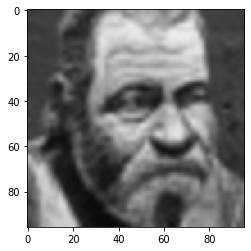

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 10s 30ms/step - loss: 1.0406 - accuracy: 0.6181 - precision: 0.7056 - recall: 0.5231
 Testing Acc :  0.6181387305259705
 Testing Precision  0.7055618166923523
 Testing Recall  0.5231262445449829


In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")